In [4]:
# what is the increase in PPI / PDI from 
# testing multiple isoforms per gene
import pandas as pd

from data_loading import load_y2h_isoform_data, load_y1h_pdi_data, load_annotated_6k_collection

y2h = load_y2h_isoform_data()
y1h = load_y1h_pdi_data()
tfs = load_annotated_6k_collection()
# TODO: add filtering as an argument
tfs = {k: v for k, v in tfs.items() if len(v.cloned_isoforms) >= 2}

100%|██████████| 1635/1635 [00:08<00:00, 192.05it/s]


In [5]:
tfs['ARNTL'].cloned_reference_isoform

Clone acc: ARNTL|1/2|08H08
Isoform: ARNTL-201 / ENSP00000374357 / ENST00000389707
length: 625 aa

In [6]:
# number of cloned, uncloned and novel isoforms
df = pd.DataFrame([(name, tf.cloned_MANE_select_isoform) for name, tf in tfs.items()],
             columns=['gene', 'cloned_MANE_select_isoform'])
df.head()

,gene,cloned_MANE_select_isoform
0,ZBTB18,True
1,PRRX1,True
2,POU2F1,False
3,ATF3,True
4,GRHL3,True


In [6]:
df.shape

(246, 2)

In [8]:
df['cloned_MANE_select_isoform'].value_counts(dropna=False)

True     164
False     65
NaN       17
Name: cloned_MANE_select_isoform, dtype: int64

In [21]:
df.loc[df['cloned_MANE_select_isoform'].isnull()]

,gene,cloned_MANE_select_isoform
49,ELF2,None
50,ZNF131,None
67,PLAGL1,None
68,TEAD3,None
105,CREM,None
111,EBF3,None
113,ZNF438,None
127,SOX6,None
149,ZBTB1,None
154,OTX2,None


In [22]:
df.loc[df['cloned_MANE_select_isoform'] == False]

,gene,cloned_MANE_select_isoform
2,POU2F1,False
12,NR5A2,False
14,PRDM16,False
20,ESRRG,False
21,ZNF692,False
...,...,...
229,TEAD2,False
232,ZNF414,False
238,PATZ1,False
243,HDX,False


In [12]:
cloned_reference = {cloned_reference_isoform(tf).clone_acc for tf in tfs.values()}

In [29]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [50]:
n_ppi_gene = (y2h.loc[y2h['Y2H_result'] == True, :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
n_ppi_isoform = (y2h.loc[(y2h['Y2H_result'] == True) &
                         y2h['ad_clone_acc'].isin(cloned_reference), :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
ppi_increase = n_ppi_gene - n_ppi_isoform
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{ppi_increase.sum()} total PPIs '
      f'({n_ppi_gene.sum()} total, '
      f'+{ppi_increase.sum() / (n_ppi_gene.sum() - ppi_increase.sum()):.1%})')
print(f'{(ppi_increase > 0).sum()} of '
      f'{ppi_increase.shape[0]} genes had ≥ 1 extra PPI'
      f' ({(ppi_increase > 0).mean():.0%})')
# average per gene

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
176.0 total PPIs (797 total, +28.3%)
19 of 63 genes had ≥ 1 extra PPI (30%)


In [9]:
from matplotlib import pyplot as plt

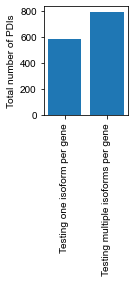

In [45]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_ppi_isoform.sum(), n_ppi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/ppi_increase.pdf',
            bbox_inches='tight')


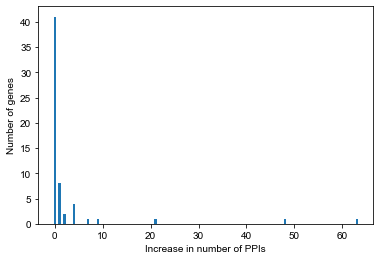

In [51]:
fig, ax = plt.subplots(1, 1)
ppi_increase.plot.hist(bins=int(ppi_increase.max()) * 2 + 1,
                       range=(-0.25, ppi_increase.max() + 0.25),
                       ax=ax)
ax.set_ylabel('Number of genes')
ax.set_xlabel('Increase in number of PPIs')
fig.savefig('../figures/PPI_increase_hist.pdf',
            bbox_inches='tight')

In [55]:
ppi_increase.sort_values(ascending=False).head()

ad_gene_symbol
ZNF451     63.0
IKZF2      48.0
ZNF438     21.0
ZSCAN18     9.0
ZBTB44      7.0
Name: db_gene_symbol, dtype: float64

In [44]:
# check the increase is not due to lots of failed tests with the reference
(y2h.loc[(y2h['Y2H_result'].isnull()) &
                         y2h['ad_clone_acc'].isin(cloned_reference), :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique()).sum()

12

In [46]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [47]:
n_ppi_gene = (y2h.loc[y2h['ad_gene_symbol'].isin(cloned_MANE), :].loc[y2h['Y2H_result'] == True, :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
n_ppi_isoform = (y2h.loc[y2h['ad_gene_symbol'].isin(cloned_MANE), :].loc[(y2h['Y2H_result'] == True) &
                         y2h['ad_clone_acc'].isin(cloned_reference), :]
    .groupby('ad_gene_symbol')
    ['db_gene_symbol'].nunique())
ppi_increase = n_ppi_gene - n_ppi_isoform
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{ppi_increase.sum()} total PPIs '
      f'({n_ppi_gene.sum()} total, '
      f'+{ppi_increase.sum() / (n_ppi_gene.sum() - ppi_increase.sum()):.1%})')
print(f'{(ppi_increase > 0).sum()} of '
      f'{ppi_increase.shape[0]} genes had ≥ 1 extra PPI'
      f' ({(ppi_increase > 0).mean():.0%})')
# average per gene

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
27.0 total PPIs (532 total, +5.3%)
11 of 42 genes had ≥ 1 extra PPI (26%)


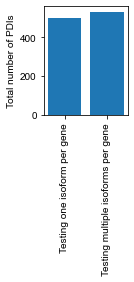

In [48]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_ppi_isoform.sum(), n_ppi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/ppi_increase_MANE_only.pdf',
            bbox_inches='tight')

In [35]:
n_pdi_gene = y1h.groupby('tf').any().iloc[:, 1:].sum(axis=1)
n_pdi_isoform = y1h.loc[y1h['unique_acc'].isin(cloned_reference), :].groupby('tf').any().iloc[:, 1:].sum(axis=1)

n_pdi_gene = n_pdi_gene.loc[n_pdi_isoform.index]

pdi_increase = (n_pdi_gene - n_pdi_isoform).fillna(n_pdi_gene)
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{pdi_increase.sum()} total PDIs '
      f'({n_pdi_gene.sum()} total, '
      f'+{pdi_increase.sum() / (n_pdi_gene.sum() - pdi_increase.sum()):.1%})')
print(f'{(pdi_increase > 0).sum()} of '
      f'{pdi_increase.shape[0]} genes had ≥ 1 extra PDI'
      f' ({(pdi_increase > 0).mean():.0%})')

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
49 total PDIs (316 total, +18.4%)
16 of 56 genes had ≥ 1 extra PDI (29%)


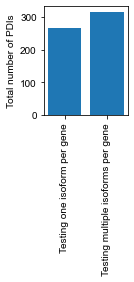

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_pdi_isoform.sum(), n_pdi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/pdi_increase.pdf',
            bbox_inches='tight')


In [40]:
cloned_MANE = set(df.loc[df['cloned_MANE_select_isoform'] == True, 'gene'].values)

In [42]:
n_pdi_gene = y1h.loc[y1h['tf'].isin(cloned_MANE), :].groupby('tf').any().iloc[:, 1:].sum(axis=1)
n_pdi_isoform = y1h.loc[y1h['tf'].isin(cloned_MANE), :].loc[y1h['unique_acc'].isin(cloned_reference), :].groupby('tf').any().iloc[:, 1:].sum(axis=1)

n_pdi_gene = n_pdi_gene.loc[n_pdi_isoform.index]

pdi_increase = (n_pdi_gene - n_pdi_isoform).fillna(n_pdi_gene)
print('Comparing to picking a reference isoform amoungst the cloned isoforms')
print('screening multiple isoforms resulted in an increase of')
print(f'{pdi_increase.sum()} total PDIs '
      f'({n_pdi_gene.sum()} total, '
      f'+{pdi_increase.sum() / (n_pdi_gene.sum() - pdi_increase.sum()):.1%})')
print(f'{(pdi_increase > 0).sum()} of '
      f'{pdi_increase.shape[0]} genes had ≥ 1 extra PDI'
      f' ({(pdi_increase > 0).mean():.0%})')

Comparing to picking a reference isoform amoungst the cloned isoforms
screening multiple isoforms resulted in an increase of
39 total PDIs (268 total, +17.0%)
12 of 42 genes had ≥ 1 extra PDI (29%)


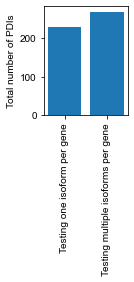

In [44]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
ax.bar(x=['Testing one isoform per gene', 'Testing multiple isoforms per gene'],
       height=[n_pdi_isoform.sum(), n_pdi_gene.sum()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total number of PDIs')
fig.savefig('../figures/pdi_increase_MANE_only.pdf',
            bbox_inches='tight')